In [2]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

def showImg(*imgs:cv2.Mat):
    cnt = len(imgs)
    if cnt == 1:
        plt.imshow(cv2.cvtColor(imgs[0], cv2.COLOR_BGR2RGB))
        plt.show()
        return
    
    for i in range(cnt):
        plt.subplot(1,cnt,i+1),plt.imshow(cv2.cvtColor(imgs[i], cv2.COLOR_BGR2RGB))
    plt.show()

### 问题一：通道交换
读取图像，然后将\text{RGB}RGB通道替换成\text{BGR}BGR通道。

下面的代码用于提取图像的红色通道。
> 注意，cv2.imread() 的系数是按 **BGR** 顺序排列的！

> 其中的变量red表示的是仅有原图像红通道的imori.jpg。

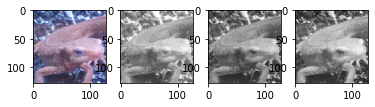

In [4]:
img = cv2.imread("imori.jpg")
# red = img[:,:,2].copy()
# B/G/R
showImg(img,img[...,0],img[...,1],img[...,2])

### 问题二：灰度化（Grayscale）
将图像灰度化吧！

灰度是一种图像亮度的表示方法，通过下式计算：

$Y = 0.2126\ R + 0.7152\ G + 0.0722\ B$

$Y=0.2126 R+0.7152 G+0.0722 B$

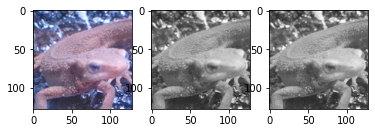

In [6]:
def BGR2GRAY(img:cv2.Mat):
    return ((img[:,:,0] * 0.0722) + (img[:,:,1] * 0.7152) + (img[:,:,2] * 0.2126)).astype(np.uint8)
    
gray1 = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
showImg(img,BGR2GRAY(img),gray1)

### 问题三：二值化（Thresholding）
把图像进行二值化吧。

二值化是将图像使用黑和白两种颜色表示的方法。

我们将灰度的阈值设置为128128来进行二值化，即：

$
y=\begin{cases}
0& (\text{if}\quad y < 128) \\
255& (\text{else})
\end{cases}$

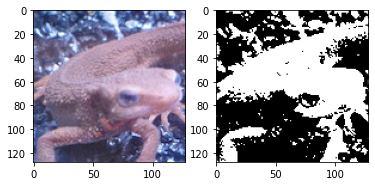

In [7]:
# 图像二值化
def binarization(img:cv2.Mat,th=128)->cv2.Mat:
    if img.shape[2] == 3: # 转换为灰度图
        img = BGR2GRAY(img)
    img[img<th] = 0
    img[img>=th] = 255
    return img


showImg(img,binarization(img))

### 问题四：大津二值化算法（Otsu's Method）

大津算法，也被称作最大类间方差法，是一种可以自动确定二值化中阈值的算法。

从**类内方差**和**类间方差**的比值计算得来：

- 小于阈值$t$的类记作$0$，大于阈值$t$的类记作$1$；
- $w_0$和$w_1$是被阈值$t$分开的两个类中的像素数占总像素数的比率（满足$w_0+w_1=1$）；
- ${S_0}^2$， ${S_1}^2$是这两个类中像素值的方差；
- $M_0$，$M_1$是这两个类的像素值的平均值；

即：

* 类内方差：${S_w}^2=w_0\ {S_0}^2+w_1\  {S_1}^2$
* 类间方差：${S_b}^2 = w_0 \  (M_0 - M_t)^2 + w_1\ (M_1 - M_t)^2 = w_0\  w_1\  (M_0 - M_1) ^2$
* 图像所有像素的方差：${S_t}^2 = {S_w}^2 + {S_b}^2 = \text{常数}$

根据以上的式子，我们用以下的式子计算分离度$X$：[^1]

[^1]: 这里原repo配图里的公式好像打错了。

$$
X = \frac{{S_b}^2}{{S_w}^2} = \frac{{S_b}^2}{{S_t}^2 - {S_b}^2}
$$

也就是说： 
$$
\arg\max\limits_{t}\ X=\arg\max\limits_{t}\ {S_b}^2
$$
换言之，如果使${S_b}^2={w_0}\ {w_1}\ (M_0 - M_1)^2$最大，就可以得到最好的二值化阈值$t$。

threshold >> 127


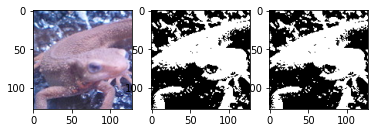

In [9]:
# 大津二值化算法
def Otsu(img:cv2.Mat) -> cv2.Mat:
    if img.shape[2] == 3:  # 转换为灰度图
        img = BGR2GRAY(img)
    if img.dtype.name == 'uint8':
        img.astype(np.float32)

    out = img
    H, W = img.shape
    max_sigma = 0
    max_t = 0

    # determine threshold
    for _t in range(1, 255):
        v0 = out[np.where(out < _t)]
        m0 = np.mean(v0) if len(v0) > 0 else 0.
        w0 = len(v0) / (H * W)
        v1 = out[np.where(out >= _t)]
        m1 = np.mean(v1) if len(v1) > 0 else 0.
        w1 = len(v1) / (H * W)
        sigma = w0 * w1 * ((m0 - m1) ** 2)
        if sigma > max_sigma:
            max_sigma = sigma
            max_t = _t

    # Binarization
    print("threshold >>", max_t)
    th = max_t
    out[out < th] = 0
    out[out >= th] = 255
    return out


showImg(img, Otsu(img),binarization(img))


### 问题五：**HSV** 变换
将使用\text{HSV}HSV表示色彩的图像的色相反转吧！

**HSV** 即使用**色相（Hue）、饱和度（Saturation）、明度（Value）**来表示色彩的一种方式。

- 色相：将颜色使用$0^{\circ}$到$360^{\circ}$表示，就是平常所说的颜色名称，如红色、蓝色。色相与数值按下表对应：

  | 红          | 黄           | 绿            | 青色          | 蓝色          | 品红          | 红            |
  | ----------- | ------------ | ------------- | ------------- | ------------- | ------------- | ------------- |
  | $0^{\circ}$ | $60^{\circ}$ | $120^{\circ}$ | $180^{\circ}$ | $240^{\circ}$ | $300^{\circ}$ | $360^{\circ}$ |

- 饱和度：是指色彩的纯度，饱和度越低则颜色越黯淡（$0\leq S < 1$）；
- 明度：即颜色的明暗程度。数值越高越接近白色，数值越低越接近黑色（$0\leq V < 1$）；

从$\text{RGB}$色彩表示转换到$\text{HSV}$色彩表示通过以下方式计算：

$\text{RGB}$的取值范围为$[0, 1]$，令：
$$
\text{Max}=\max(R,G,B)\\
\text{Min}=\min(R,G,B)
$$
色相：
$$
H=\begin{cases}
0&(\text{if}\ \text{Min}=\text{Max})\\
60\  \frac{G-R}{\text{Max}-\text{Min}}+60&(\text{if}\ \text{Min}=B)\\
60\  \frac{B-G}{\text{Max}-\text{Min}}+180&(\text{if}\ \text{Min}=R)\\
60\  \frac{R-B}{\text{Max}-\text{Min}}+300&(\text{if}\ \text{Min}=G)
\end{cases}
$$
饱和度：
$$
S=\text{Max}-\text{Min}
$$
明度：
$$
V=\text{Max}
$$
从$\text{HSV}$色彩表示转换到$\text{RGB}$色彩表示通过以下方式计算：
$$
C = S\\
H' = \frac{H}{60}\\
X = C\  (1 - |H' \mod 2 - 1|)\\
(R,G,B)=(V-C)\ (1,1,1)+\begin{cases}
(0, 0, 0)&  (\text{if H is undefined})\\
(C, X, 0)&  (\text{if}\quad 0 \leq H' < 1)\\
(X, C, 0)&  (\text{if}\quad 1 \leq H' < 2)\\
(0, C, X)&  (\text{if}\quad 2 \leq H' < 3)\\
(0, X, C)&  (\text{if}\quad 3 \leq H' < 4)\\
(X, 0, C)&  (\text{if}\quad 4 \leq H' < 5)\\
(C, 0, X)&  (\text{if}\quad 5 \leq H' < 6)
\end{cases}
$$

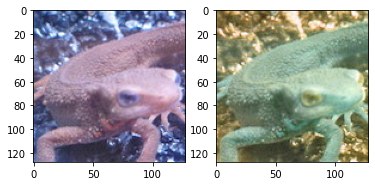

In [10]:
def BGR2HSV(img: cv2.Mat):
	img = (img.copy() / 255.).astype(np.float32)
	hsv = np.zeros_like(img, dtype=np.float32)

	# get max and min
	max_v = np.max(img, axis=2)
	min_v = np.min(img, axis=2)
	min_arg = np.argmin(img, axis=2)

	# H
	hsv[..., 0][np.where(max_v == min_v)]= 0
	# if min == B
	ind = np.where(min_arg == 0)
	hsv[..., 0][ind] = 60 * (img[..., 1][ind] - img[..., 2][ind]) / (max_v[ind] - min_v[ind]) + 60
	# if min == R
	ind = np.where(min_arg == 2)
	hsv[..., 0][ind] = 60 * (img[..., 0][ind] - img[..., 1][ind]) / (max_v[ind] - min_v[ind]) + 180
	# if min == G
	ind = np.where(min_arg == 1)
	hsv[..., 0][ind] = 60 * (img[..., 2][ind] - img[..., 0][ind]) / (max_v[ind] - min_v[ind]) + 300
		
	# S
	hsv[..., 1] = max_v.copy() - min_v.copy()

	# V
	hsv[..., 2] = max_v.copy()
	return hsv

def HSV2BGR(hsv):
	out = np.zeros_like(hsv,dtype=np.float32)

	H = hsv[..., 0]
	S = hsv[..., 1]
	V = hsv[..., 2]

	C = S
	H_ = H / 60.
	X = C * (1 - np.abs( H_ % 2 - 1))
	Z = np.zeros_like(H)

	vals = [[Z,X,C], [Z,C,X], [X,C,Z], [C,X,Z], [C,Z,X], [X,Z,C]]

	for i in range(6):
		ind = np.where((i <= H_) & (H_ < (i+1)))
		out[..., 0][ind] = (V - C)[ind] + vals[i][0][ind]
		out[..., 1][ind] = (V - C)[ind] + vals[i][1][ind]
		out[..., 2][ind] = (V - C)[ind] + vals[i][2][ind]

	out = np.clip(out, 0, 1)
	out = (out * 255).astype(np.uint8)

	return out

# RGB > HSV
hsv = BGR2HSV(img)

# Transpose Hue
hsv[..., 0] = (hsv[..., 0] + 180) % 360

# HSV > RGB
out = HSV2BGR(hsv)
showImg(img, out)

问题六：色彩空间压缩 (减色处理)

我们将图像的值由$256^3$压缩至$4^3$，即将$\text{RGB}$的值只取$\{32, 96, 160, 224\}$。这被称作色彩量化。色彩的值按照下面的方式定义：
$$
\text{val}=
\begin{cases}
32& (0 \leq \text{var} <  64)\\
96& (64\leq \text{var}<128)\\
160&(128\leq \text{var}<192)\\
224&(192\leq \text{var}<256)
\end{cases}
$$


dicrease_color dtype uint8


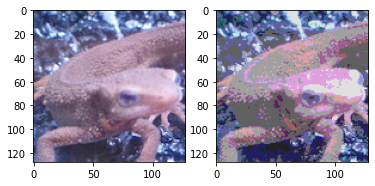

In [60]:
# 图像色彩由256^3 压缩至4^3
def dicrease_color(img:cv2.Mat):
    return img.copy() // 64 * 64 + 32

print("dicrease_color dtype",dicrease_color(img).dtype.name)
showImg(img,dicrease_color(img))

### 问题七：平均池化（Average Pooling） *马赛克*
将图片按照固定大小网格分割，网格内的像素值取网格内所有像素的平均值。

我们将这种把图片使用均等大小网格分割，并求网格内代表值的操作称为池化（Pooling）。

池化操作是**卷积神经网络（Convolutional Neural Network）**中重要的图像处理方式。平均池化按照下式定义：
$v=\frac{1}{|R|}\  \sum\limits_{i=1}^R\ v_i$

请把大小为$128\times128$的`imori.jpg`使用$8\times8$的网格做平均池化。

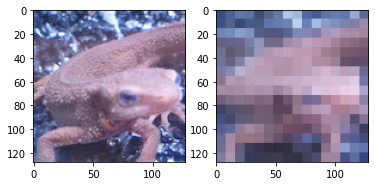

In [11]:
# 平均池 (马赛克)
def averagePooling(img:cv2.Mat,G=8):
    out = img.copy()
    H, W, C = img.shape
    Nh = int(H / G)
    Nw = int(W / G)

    for y in range(Nh):
        for x in range(Nw):
            for c in range(C):
                y1,y2, x1,x2 = G*y,G*(y+1), G*x,G*(x+1)
                out[y1:y2,x1:x2, c] = np.mean(out[y1:y2,x1:x2, c])
    
    return out.astype(np.uint8)

showImg(img,averagePooling(img))


### 问题八：最大池化（Max Pooling）
网格内的值不取平均值，而是取网格内的最大值进行池化操作

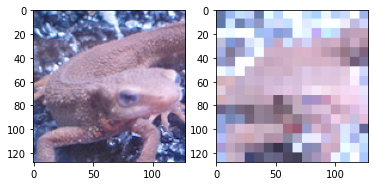

In [12]:
def maxPooling(img:cv2.Mat,G=8):
    out = img.copy()
    H, W, C = img.shape
    Nh = int(H / G)
    Nw = int(W / G)

    for y in range(Nh):
        for x in range(Nw):
            for c in range(C):
                y1,y2, x1,x2 = G*y , G*(y+1), G*x,G*(x+1)
                out[y1:y2,x1:x2, c] = np.max(out[y1:y2,x1:x2, c])
    return out.astype(np.uint8)

showImg(img,maxPooling(img))

### 问题九：高斯滤波（Gaussian Filter）
使用高斯滤波器（3\times33×3大小，标准差\sigma=1.3σ=1.3）来对imori_noise.jpg进行降噪处理吧！